## Import Dataset

In [1]:
import pandas as pd

flight_data = pd.read_csv('data/USCarrier_Traffic_2010-2019.csv')
flight_data.head()

,Period,Total
0,Jan-10,7323
1,Feb-10,6456
2,Mar-10,8062
3,Apr-10,7407
4,May-10,7863


## Data preprocessing
The types of the columns in our dataset is object
* Set data type of the ***Total*** column to *float*

In [2]:
all_data = flight_data['Total'].values.astype(float)

print(all_data[:5])

[7323. 6456. 8062. 7407. 7863.]


### Split data into training and test sets

In [3]:
total_months = flight_data.shape[0]
print('Total number of months:', total_months)

months = total_months%12
years = (total_months - months)/12
print('=', years, 'years', months, 'months')

Total number of months: 117
= 9.0 years 9 months


In [4]:
test_size = 9

data_trn = all_data[:-test_size]
data_tst = all_data[-test_size:]

print('Train data:', len(data_trn))
print('Test data:', len(data_tst))

Train data: 108
Test data: 9


### Normalize the training dataset

#### Plot the monthly passenger frequency from Training data

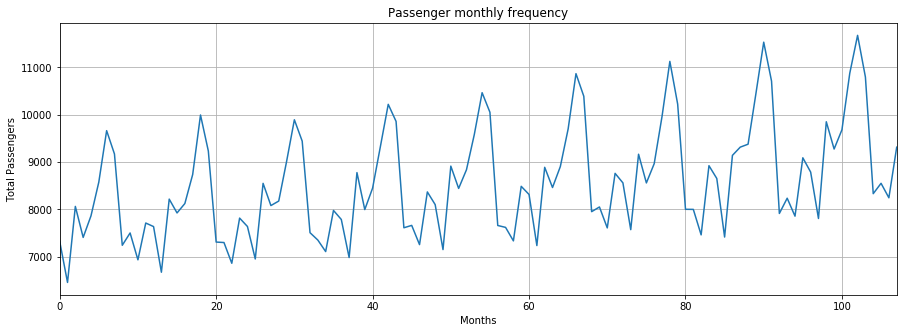

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"][0] = 15
plt.rcParams["figure.figsize"][1] = 5
plt.figure()
plt.title('Passenger monthly frequency')
plt.xlabel('Months')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data_trn)
plt.show()

The total number of passengers in the initial years is far less compared to the total number of passengers in the later years. So, we normalize the training data for time series predictions.  

#### Perform *min/max scaling*
[Ref](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
* Keep the dataset values between -1 and 1.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

data_trn_norm = scaler.fit_transform(data_trn.reshape(-1, 1))

print('After Normalization')
print('First 5 records:', data_trn_norm[:5])
print('Last 5 records:', data_trn_norm[-5:])

After Normalization
First 5 records: [[-0.66775244]
 [-1.        ]
 [-0.38455643]
 [-0.63556237]
 [-0.46081625]]
Last 5 records: [[ 0.66277065]
 [-0.28147155]
 [-0.19754742]
 [-0.31481127]
 [ 0.09484576]]


### Convert the normalized training data to Tensor

In [7]:
import torch

data_trn_norm_tensor = torch.FloatTensor(data_trn_norm).view(-1)

### Convert the training data into sequences and labels
* Accept raw input data
* Return a list of tuples
  * First element = list of 12 items: the number of passengers traveling in 12 months
  * Second element = one item: the number of passengers in the 12+1st month
* Sequence length / Training window = 12, since there are 12 months
  * Based on domain knowledge
* No. of sequence_labels data = 96
  * Total no. of train data - Length of sequence = 108 - 12 = 96

In [8]:
def create_seq_labels(input_data, train_window):
    l = len(input_data)
    tw = train_window
    seq_labels = []
    for i in range(l-tw):
        seq = input_data[i:i+tw]
        label = input_data[i+tw:i+tw+1]
        seq_labels.append((seq, label))
    return seq_labels

seq_labels_trn = create_seq_labels(data_trn_norm_tensor, 12)
print(len(seq_labels_trn), 'sequence_label training data')  
print('First 5:\n', seq_labels_trn[:5])

96 sequence_label training data
First 5:
 [(tensor([-0.6678, -1.0000, -0.3846, -0.6356, -0.4608, -0.1876,  0.2286,  0.0400,
        -0.6992, -0.5995, -0.8168, -0.5191]), tensor([-0.5478])), (tensor([-1.0000, -0.3846, -0.6356, -0.4608, -0.1876,  0.2286,  0.0400, -0.6992,
        -0.5995, -0.8168, -0.5191, -0.5478]), tensor([-0.9172])), (tensor([-0.3846, -0.6356, -0.4608, -0.1876,  0.2286,  0.0400, -0.6992, -0.5995,
        -0.8168, -0.5191, -0.5478, -0.9172]), tensor([-0.3255])), (tensor([-0.6356, -0.4608, -0.1876,  0.2286,  0.0400, -0.6992, -0.5995, -0.8168,
        -0.5191, -0.5478, -0.9172, -0.3255]), tensor([-0.4374])), (tensor([-0.4608, -0.1876,  0.2286,  0.0400, -0.6992, -0.5995, -0.8168, -0.5191,
        -0.5478, -0.9172, -0.3255, -0.4374]), tensor([-0.3612]))]


## Create model

### Define the model
* Create LSTM model class that inherits from the ***Module*** class of **PyTorch**'s **nn** module
* Initialization:
  * **input size**: number of features in the input
    * For each month we have only 1 value for total passengers => input size is 1
  * **hidden_layer_size**: list of neurons in each hidden layer
  * **output size**: number of items in the output
    * To predict no. of passengers for 1 month in future => output size is 1
* Constructor Variables:
  * **hidden_layer_size**: Neurons for each hidden layer
  * **lstm**: LSTM layer; accepts input_size and hidden_layers
  * **linear**: Linear layer
  * **hidden_cell**: previous hidden and cell states
* Passing inputs and predicting:
  * The input_seq is passed to the lstm layer
  * Hidden and cell states are obtain along with the lstm output
  * Lstm output is passed through the linear layer
  * Prediction is obtained and stored

In [9]:
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq),-1))
        return predictions[-1]
    

### Prepare the model
* Set loss function: **MSE** loss
* Set optimizer: **Adam**

In [10]:
model = LSTM()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(1, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)


## Train the model
* Set the number of epochs
* Weights are initialized randomly in a *PyTorch* neural network
* Reset optimizer
* Find the hidden and cell states
* Make prediction
* Find loss
* Update weights
* Update gradient for optimizing

In [11]:
epochs = 250

for i in range(epochs):
    for seq, label in seq_labels_trn:     
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size), torch.zeros(1,1,model.hidden_layer_size))
        pred = model(seq)
        loss = loss_function(pred, label)
        loss.backward()
        optimizer.step()
    if i%20 == 1:
        print(f'epoch: {i:3} loss: {loss.item():10.5f}')

print(f'epoch: {i:3} loss: {loss.item():10.5f}')

epoch:   1 loss:    0.11223
epoch:  21 loss:    0.03978
epoch:  41 loss:    0.00793
epoch:  61 loss:    0.00005
epoch:  81 loss:    0.00154
epoch: 101 loss:    0.00958
epoch: 121 loss:    0.00029
epoch: 141 loss:    0.00657
epoch: 161 loss:    0.00015
epoch: 181 loss:    0.00226
epoch: 201 loss:    0.00000
epoch: 221 loss:    0.00003
epoch: 241 loss:    0.00025
epoch: 249 loss:    0.00020


## Test the model
* Use the last 12 months values from the training set to use for prediction

In [12]:
test_inputs = data_trn_norm_tensor[-12:].tolist()
print(test_inputs)

[-0.10672542452812195, -0.4822762906551361, 0.3006322979927063, 0.079900361597538, 0.23586894571781158, 0.6930446624755859, 1.0, 0.6627706289291382, -0.2814715504646301, -0.19754742085933685, -0.31481125950813293, 0.09484575688838959]


### Predict the future 9 months values
* Initially the test input contains 12 items
* These 12 items are used to make prediction for the next item, i.e. the first item from the test set (item 109)
* The predicted value is then appended to the test inputs list
* For the next iteration the last 12 items of the test inputs will be used
* There will be 9 iterations for the 9 predictions
* In the end the test inputs will contaion 12+9 = 21 items, out of which the last 9 items will be the predicted values for the test set.

In [13]:
fut_pred=9

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-12:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))   
        test_inputs.append(model(seq).item())
        
final_predictions = test_inputs[-fut_pred:]
print(final_predictions)

[0.03338109329342842, -0.25540691614151, 0.37114059925079346, 0.168283611536026, 0.605070948600769, -0.3531736433506012, -0.04228045791387558, 0.19453324377536774, -0.3580143451690674]


### Denormalize the predicted values

Since the dataset for training was normalized, the predicted values are also normalized. So, we convert the normalized predicted values into actual predicted values.

In [14]:
import numpy as np

actual_predictions = scaler.inverse_transform(np.array(final_predictions).reshape(-1,1))
print(actual_predictions)

[[ 9152.60796295]
 [ 8399.01565233]
 [10033.99139374]
 [ 9504.6360843 ]
 [10644.43264037]
 [ 8143.89337768]
 [ 8955.16914507]
 [ 9573.13449963]
 [ 8131.26156628]]


### Compare the predicted values against the actual test data
* Create a list of indices for the test set: 108-116 (last 9 records)
* plot the total number of passengers for last 9 months, along with the predicted number of passengers for the last 9 months

In [15]:
x = np.arange(108, 117, 1)
print(x)

[108 109 110 111 112 113 114 115 116]


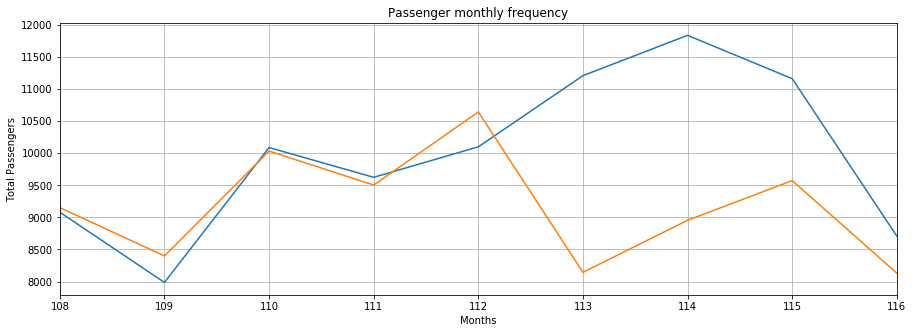

In [16]:
plt.figure()
plt.title('Passenger monthly frequency')
plt.xlabel('Months')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['Total'][-9:])
plt.plot(x, actual_predictions)
plt.show()

In [18]:
plt.savefig('last_9_months_prediction.png')

<Figure size 1080x360 with 0 Axes>

## Save the model

In [17]:
import pickle

pickle.dump(model, open('model.sav', 'wb'))